### Import des bibliothèques

In [3]:
### Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor
%pip install scikit-optimize
from skopt import BayesSearchCV  # Recherche bayésienne pour hyperparamètres


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Chargement des données d'entraînement
- Chargement du fichier `train.csv` dans un DataFrame

In [4]:
df = pd.read_csv('train.csv')

### Visualisation des valeurs manquantes avant remplissage

- Visualisation de la proportion des valeurs manquantes dans chaque colonne


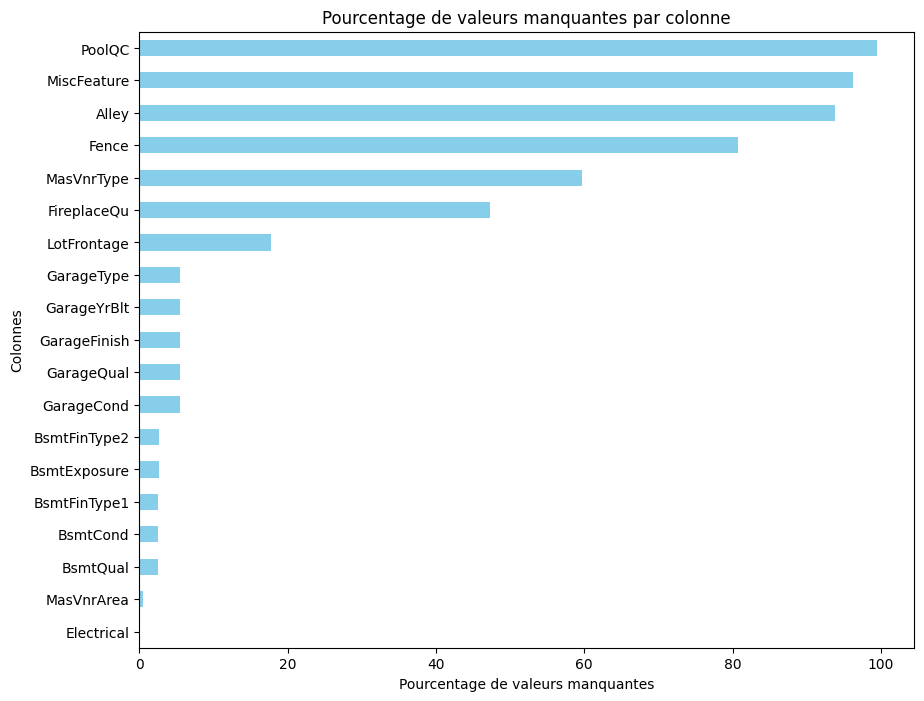

In [5]:
missing_values = df.isnull().mean() * 100
missing_values = missing_values[missing_values > 0]
plt.figure(figsize=(10, 8))
missing_values.sort_values().plot(kind='barh', color='skyblue')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Pourcentage de valeurs manquantes')
plt.ylabel('Colonnes')
plt.show()

### Remplissage des valeurs manquantes par la médiane
- Remplissage des valeurs manquantes pour les colonnes numériques par leur médiane
- Remplissage des valeurs manquantes pour les colonnes catégorielles par leur mode

In [6]:
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-6-cf4d3ab63ada>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-6-cf4d3ab63ada>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

### Création de nouvelles variables
- Création des variables TotalSF, TotalBath et TotalPorchSF

In [7]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

### Visualisation des valeurs aberrantes avant suppression

- Graphique scatter pour visualiser GrLivArea contre SalePrice avant la suppression des valeurs aberrantes

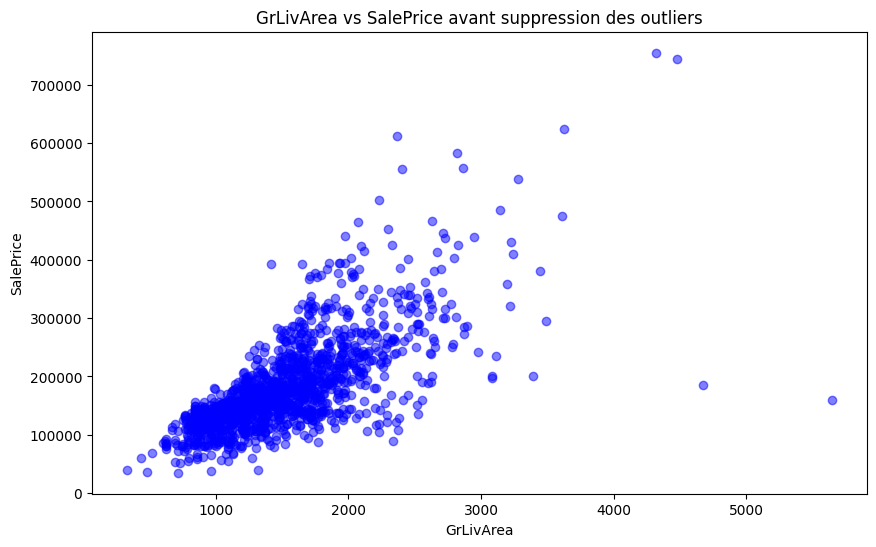

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['GrLivArea'], df['SalePrice'], color='blue', alpha=0.5)
plt.title('GrLivArea vs SalePrice avant suppression des outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

### Suppression des outliers basés sur GrLivArea et SalePrice

In [9]:
df = df.drop(df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index)

### Visualisation des valeurs aberrantes après suppression

- Graphique scatter pour visualiser GrLivArea contre SalePrice après la suppression des valeurs aberrantes

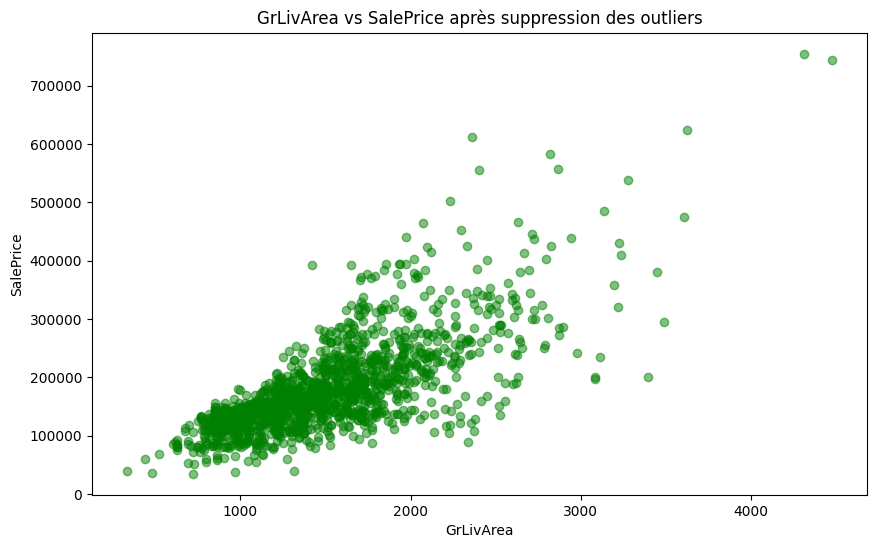

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['GrLivArea'], df['SalePrice'], color='green', alpha=0.5)
plt.title('GrLivArea vs SalePrice après suppression des outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

### Transformation logarithmique de SalePrice

In [11]:
df["SalePrice"] = np.log1p(df["SalePrice"])

### Visualisation de la distribution de SalePrice après transformation

- Affichage de la distribution de SalePrice avant et après la transformation logarithmique

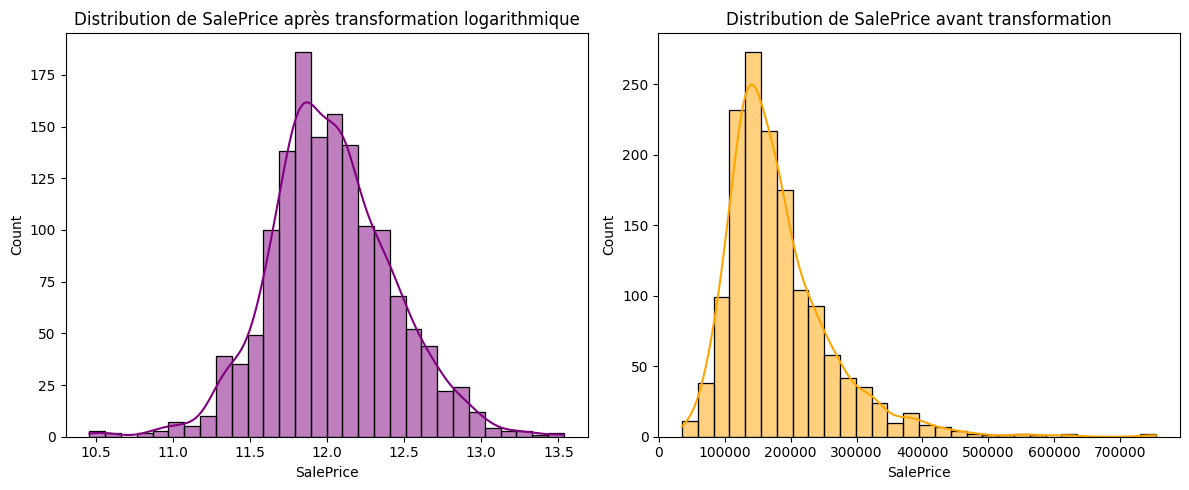

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["SalePrice"], bins=30, kde=True, color='purple')
plt.title('Distribution de SalePrice après transformation logarithmique')

plt.subplot(1, 2, 2)
sns.histplot(np.expm1(df["SalePrice"]), bins=30, kde=True, color='orange')
plt.title('Distribution de SalePrice avant transformation')

plt.tight_layout()
plt.show()

### Séparation des caractéristiques et de la cible
- Séparation des caractéristiques (X) et de la variable cible (y)

In [13]:
X = df.drop(columns=['SalePrice', 'Id'])
y = df['SalePrice']

### Encodage des variables catégorielles

In [14]:
X = pd.get_dummies(X, drop_first=True)

### Division en ensemble d'entraînement et de test
- Division des données en ensemble d'entraînement et de test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Normalisation des colonnes numériques

In [16]:
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Configuration des modèles et recherche bayésienne d’hyperparamètres

- Initialisation des modèles avec recherche bayésienne pour le tuning des hyperparamètres

In [17]:
models = {}

> RandomForest avec recherche bayésienne

In [18]:
# Importation de RandomForestRegressor de scikit-learn (CPU uniquement)
from sklearn.ensemble import RandomForestRegressor  # Utilisation de RandomForest CPU

# Importation de BayesSearchCV de scikit-optimize pour l'optimisation bayésienne
from skopt import BayesSearchCV

# Configuration de la recherche bayésienne avec RandomForest (CPU)
rf_search = BayesSearchCV(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    search_spaces={
        'n_estimators': (50, 500),
        'max_depth': (5, 50),
        'min_samples_split': (2, 10)
    },
    n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42
)

# Exécution de l'optimisation bayésienne
rf_search.fit(X_train, y_train)
models = {"Random Forest": rf_search.best_estimator_}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


> XGBoost avec recherche bayésienne

In [19]:
xgb_search = BayesSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    search_spaces={'n_estimators': (50, 500), 'max_depth': (3, 10), 'learning_rate': (0.01, 0.2, 'log-uniform')},
    n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42
)
xgb_search.fit(X_train, y_train)
models["XGBoost"] = xgb_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most r

> LightGBM avec recherche bayésienne

In [20]:
lgb_search = BayesSearchCV(
    estimator=lgb.LGBMRegressor(objective='regression', random_state=42),
    search_spaces={'num_leaves': (20, 50), 'learning_rate': (0.01, 0.2, 'log-uniform'), 'n_estimators': (50, 500)},
    n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42
)
lgb_search.fit(X_train, y_train)
models["LightGBM"] = lgb_search.best_estimator_

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3543
[LightGBM] [Info] Number of data points in the train set: 1050, number of used features: 150
[LightGBM] [Info] Start training from score 12.023967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

### Stacking des meilleurs modèles

- Utilisation de StackingCVRegressor pour empiler les modèles sélectionnés

In [21]:
stacked_model = StackingCVRegressor(
    regressors=[models["Random Forest"], models["XGBoost"], models["LightGBM"]],
    meta_regressor=Lasso(alpha=0.0005),
    cv=5
)
stacked_model.fit(np.array(X_train), np.array(y_train))

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3562
[LightGBM] [Info] Number of data points in the train set: 1049, number of used features: 154
[LightGBM] [Info] Start training from score 12.019893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 1049, number of used features: 151
[LightGBM] [Info] Start training from score 12.021444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3756
[LightGBM] [Info] Number of data points in the train set: 1312, number of used features: 161
[LightGBM] [Info] Start training from score 12.024654


StackingCVRegressor(meta_regressor=Lasso(alpha=0.0005),
                    regressors=[RandomForestRegressor(max_depth=27,
                                                      n_estimators=500,
                                                      random_state=42),
                                XGBRegressor(base_score=0.5, booster='gbtree',
                                             callbacks=None,
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None, gamma=0,
                                             gpu_id=-1, grow_poli...
                                             max_bin=256, max_cat_to_onehot=4,
                                             max_delta_step=0, max_depth=6,
                                             max_leaves=0, min_child_weight=1,
                                             missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=490, n_jobs=0,
                                             num_parallel_tree=1,
                                             predictor='auto', random_state=42,
                                             reg_alpha=0, reg_lambda=1, ...),
                                LGBMRegressor(learning_rate=0.018181648766341416,
                                              n_estimators=418, num_leaves=20,
                                              objective='regression',
                                              random_state=42)])

### Évaluation sur le jeu de test

In [22]:
y_pred = stacked_model.predict(np.array(X_test))
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Performance sur le jeu de test - MSE: {test_mse:.2f}, R^2: {test_r2:.2f}")

Performance sur le jeu de test - MSE: 0.01, R^2: 0.92


### Chargement et prétraitement des données de test

- Chargement du fichier test.csv et prétraitement des données de test

In [23]:
df_test = pd.read_csv('test.csv')
df_test.fillna(0, inplace=True)
test_ids = df_test['Id']

df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['TotalBath'] = df_test['FullBath'] + 0.5 * df_test['HalfBath'] + df_test['BsmtFullBath'] + 0.5 * df_test['BsmtHalfBath']
df_test['TotalPorchSF'] = df_test['OpenPorchSF'] + df_test['3SsnPorch'] + df_test['EnclosedPorch'] + df_test['ScreenPorch'] + df_test['WoodDeckSF']
X_test_submission = pd.get_dummies(df_test.drop(columns=['Id']), drop_first=True)
X_train, X_test_submission = X_train.align(X_test_submission, join='left', axis=1, fill_value=0)
X_test_submission[numerical_cols] = scaler.transform(X_test_submission[numerical_cols])

- Prédictions et création du fichier de soumission

In [24]:
y_pred_submission = stacked_model.predict(np.array(X_test_submission))
y_pred_submission = np.expm1(y_pred_submission)
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_pred_submission
})
submission_df.to_csv('submission.csv', index=False)
print("Fichier de soumission 'submission.csv' généré.")

Fichier de soumission 'submission.csv' généré.
